In [1]:
using POMDPs # for MDP type
using DiscreteValueIteration
using POMDPPolicies
using POMDPModelTools #for sparse cat 
using Parameters
using Random
using Plots; default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style
using QuickPOMDPs
using Distributions 
using LinearAlgebra
using POMDPSimulators
using Measures
using DataStructures

In [2]:
Random.seed!(0xC0FFEE)

MersenneTwister(12648430)

**States**

In [3]:
struct State
    c::Int # chairs remaining 
    t::Int # time remaining 
    f::Int # family size 
    v::Int # visa status 
end 

**Environment Parameters**

In [4]:
@with_kw struct EvacuationParameters
    
    family_sizes::Vector{Int} = [1, 2, 3, 4, 5] 
    family_prob = [.1, .2, .3, .2, .2]
    visa_status::Vector{Int} = [-2, -1, 0, 1, 2] #TODO: map to various status strings
    visa_prob = [.1, .1, .4, .2, .2]
    
    v_stringtoint = Dict("ISIS-k"=>-2,
        "Taliban"=>-1,
        "Afghan"=>0,
        "SIV"=>1,
        "AMCIT"=>2)
    
     v_inttostring = Dict(-2=>"ISIS-k",
        -1=>"Taliban",
        0=>"Afghan",
        1=>"SIV",
        2=>"AMCIT")
    
    capacity::Int = 120 # keeping these both as integers of 20 for now. 
    time::Int = 120
    size::Tuple{Int, Int} = (length(visa_status), length(family_sizes)) # size of grid 
    p_transition::Real = 0.8 # don't we always transition into this since time moves forward? I'm confused... 
    null_state::State = State(-1, -1, -1 ,-1) # is there someway to do this???
    accept_prob = [.80, .20]
    reject_prob = [1.0]
end

EvacuationParameters

In [5]:
params = EvacuationParameters(); 

In [6]:
@show number_states = params.capacity * params.time * size(params.family_sizes)[1] * size(params.visa_status)[1]

number_states = params.capacity * params.time * (size(params.family_sizes))[1] * (size(params.visa_status))[1] = 360000


360000

In [7]:
# The state space S for the evacuation problem is the set of all combinations 
𝒮 = []
for c in 0:params.capacity # capacity ends at 0 
    for t in 0:params.time # time ends at 0 
        for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
            for v in params.visa_status # actual visa statuses 
                new = State(c, t, f, v) 
                𝒮 = [𝒮; new]
            end
        end        
    end
end
𝒮 = [𝒮; params.null_state]

366026-element Vector{Any}:
 State(0, 0, 1, -2)
 State(0, 0, 1, -1)
 State(0, 0, 1, 0)
 State(0, 0, 1, 1)
 State(0, 0, 1, 2)
 State(0, 0, 2, -2)
 State(0, 0, 2, -1)
 State(0, 0, 2, 0)
 State(0, 0, 2, 1)
 State(0, 0, 2, 2)
 State(0, 0, 3, -2)
 State(0, 0, 3, -1)
 State(0, 0, 3, 0)
 ⋮
 State(120, 120, 3, 2)
 State(120, 120, 4, -2)
 State(120, 120, 4, -1)
 State(120, 120, 4, 0)
 State(120, 120, 4, 1)
 State(120, 120, 4, 2)
 State(120, 120, 5, -2)
 State(120, 120, 5, -1)
 State(120, 120, 5, 0)
 State(120, 120, 5, 1)
 State(120, 120, 5, 2)
 State(-1, -1, -1, -1)

**Actions**

In [8]:
# the possible actions are whether accept or reject a family at the gate 
@enum Action REJECT ACCEPT

In [9]:
𝒜 = [REJECT, ACCEPT]

2-element Vector{Action}:
 REJECT::Action = 0
 ACCEPT::Action = 1

In [10]:
# only inbounds if room for the family [assuming would not separate even though might]
# and if time is available to enter the airport 
validtime(s::State) = 0 < s.t 

validtime (generic function with 1 method)

In [11]:
validcapacity(s::State) = 0 ≤ s.c # maybe try back to 0 

validcapacity (generic function with 1 method)

**Transition Function** 

In [12]:
#***** ENUMERATING OVER ALL STATES ******
function T(s::State, a::Action)
    next_states = State[]
    probabilities = Float64[] 
    
    if !validtime(s) 
        push!(next_states,params.null_state)
        push!(probabilities, 1) # double check 
    else
        if a == ACCEPT 
            next_state_accept = State(s.c - s.f, s.t - 1, 1, 1) # check if valid capacity 
            if !validcapacity(next_state_accept) 
                prob = [0,1] #no room for full family :( so we make probability 0 to accept and 1 reject
            else
                prob = params.accept_prob
            end
            for f in 1:length(params.family_sizes)
                for v in 1:length(params.visa_status)
                     #if get on plan
                    push!(next_states, State(s.c - s.f, s.t - 1, params.family_sizes[f], params.visa_status[v]))
                    push!(probabilities, prob[1] * params.visa_prob[v] * params.family_prob[f])
                     #if not
                    push!(next_states, State(s.c, s.t - 1, params.family_sizes[f], params.visa_status[v]))
                    push!(probabilities, prob[2] * params.visa_prob[v] * params.family_prob[f])                    
                end
            end
        else   #if reject     
            for f in 1:length(params.family_sizes)
                for v in 1:length(params.visa_status)
                    push!(next_states, State(s.c, s.t - 1, params.family_sizes[f], params.visa_status[v]))
                    push!(probabilities, params.reject_prob[1] * params.visa_prob[v] * params.family_prob[f])    
                end
            end  
        end
    end                
    normalize!(probabilities, 1)
    @assert sum(probabilities) ≈ 1
    return SparseCat(next_states, probabilities)
end      

T (generic function with 1 method)

**Reward Function**

In [13]:
function R(s::State, a::Action)
    # reward is just the visa status times family size i think! 
    if a == ACCEPT
        return s.v*s.f
    end
    return 0
end 

R (generic function with 1 method)

In [14]:
γ = 0.95

0.95

In [15]:
termination(s::State)= s == params.null_state # change to 1 or the other 

termination (generic function with 1 method)

**MDP Formulation**

In [16]:
abstract type Evacuation <: MDP{State, Action} end

In [17]:
c_initial = params.capacity
t_initial = params.time
f_initial = rand(params.family_sizes, 1)[1]
v_initial = rand(params.visa_status, 1)[1]
initial_state = State(c_initial, t_initial, f_initial, v_initial)
statetype = typeof(initial_state)
initialstate_array = [initial_state]

1-element Vector{State}:
 State(120, 120, 5, 0)

In [18]:
mdp = QuickMDP(Evacuation,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    discount     = γ,
    initialstate = initialstate_array, 
    isterminal   = termination,
    render       = render,
    statetype    = statetype 
    );

In [19]:
solver = ValueIterationSolver(max_iterations=30, belres=1e-6, verbose=true);

**Policy**

In [20]:
mdp_policy = solve(solver, mdp)  # look at this to see why it's not graphing anymore 

[Iteration 1   ] residual:       46.4 | iteration runtime:  16891.786 ms, (      16.9 s total)
[Iteration 2   ] residual:          0 | iteration runtime:  17504.251 ms, (      34.4 s total)


ValueIterationPolicy:
 State(0, 0, 1, -2) -> REJECT
 State(0, 0, 1, -1) -> REJECT
 State(0, 0, 1, 0) -> REJECT
 State(0, 0, 1, 1) -> ACCEPT
 State(0, 0, 1, 2) -> ACCEPT
 State(0, 0, 2, -2) -> REJECT
 State(0, 0, 2, -1) -> REJECT
 State(0, 0, 2, 0) -> REJECT
 State(0, 0, 2, 1) -> ACCEPT
 State(0, 0, 2, 2) -> ACCEPT
 State(0, 0, 3, -2) -> REJECT
 State(0, 0, 3, -1) -> REJECT
 State(0, 0, 3, 0) -> REJECT
 State(0, 0, 3, 1) -> ACCEPT
 State(0, 0, 3, 2) -> ACCEPT
 State(0, 0, 4, -2) -> REJECT
 State(0, 0, 4, -1) -> REJECT
 State(0, 0, 4, 0) -> REJECT
 State(0, 0, 4, 1) -> ACCEPT
 State(0, 0, 4, 2) -> ACCEPT
 State(0, 0, 5, -2) -> REJECT
 State(0, 0, 5, -1) -> REJECT
 State(0, 0, 5, 0) -> REJECT
 State(0, 0, 5, 1) -> ACCEPT
 State(0, 0, 5, 2) -> ACCEPT
 …

**Basesline Policies**

In [21]:
"""AcceptAll"""
struct AcceptAll <: Policy end

# accept everyone until capacity is 0
function POMDPs.action(::AcceptAll, s::State)    # action(policy, state)
    return ACCEPT
end;

AcceptAll_policy = AcceptAll()

AcceptAll()

In [22]:
"""AMCITS"""
struct AMCITS <: Policy end

# function POMDPs.action(::AMCITS, s::State)
#     return (s.v == 2)  ? ACCEPT : REJECT
# end;

function POMDPs.action(::AMCITS, s::State)
    return (s.v == params.v_stringtoint["AMCIT"])  ? ACCEPT : REJECT
end;


AMCITS_policy = AMCITS()

AMCITS()

In [23]:
"""SIV_AMCITS """
struct SIV_AMCITS <: Policy end

function POMDPs.action(::SIV_AMCITS, s::State)
    return (s.v == params.v_stringtoint["AMCIT"] || s.v == params.v_stringtoint["SIV"]) ? ACCEPT : REJECT
end;
SIV_AMCITS_policy = SIV_AMCITS()

SIV_AMCITS()

In [24]:
"""AfterThresholdAMCITS"""
# if want to change this need to make it a mutable struct 
@with_kw struct AfterThresholdAMCITS <: Policy
    threshold = 20 # could define this in parameters 
end

function POMDPs.action(policy::AfterThresholdAMCITS, s::State)
    if s.t <= 20 #policy.threshold
        return s.v == params.v_stringtoint["AMCIT"] ? ACCEPT : REJECT
    else
        return action(mdp_policy, s)
    end
end

AfterThresholdAMCITS_policy = AfterThresholdAMCITS()

AfterThresholdAMCITS
  threshold: Int64 20


In [25]:
"""BeforeThresholdAMCITS"""
@with_kw struct BeforeThresholdAMCITS <: Policy
    threshold = 20
end

function POMDPs.action(policy::BeforeThresholdAMCITS, s::State)
    if s.t >= 20 #policy.threshold
        return s.v == params.v_stringtoint["AMCIT"] ? ACCEPT : REJECT
    else
        return action(mdp_policy, s)
    end
end
        
BeforeThresholdAMCITS_policy = BeforeThresholdAMCITS()
#simulations(BeforeThresholdAMCITS_policy, mdp, 10)
# could play with changing this threshold


BeforeThresholdAMCITS
  threshold: Int64 20


**Simulation**

In [26]:
"""Given a history of a simulation, return metrics."""
function get_metrics(history)
    total_accepted_people = 0
    total_accepted_families = 0 
    total_rejected_people = 0
    total_rejected_families = 0
    total_reward = 0.0
    # Initialize visa_statuses dictionary
    visa_statuses = params.visa_status
    visa_dict_accepts = Dict(0=>0) # make dictionaries accept just ints 
    for v in visa_statuses
        visa_dict_accepts[v] = 0
    end
    
    visa_dict_rejects = Dict()
    for v in visa_statuses
        visa_dict_rejects[v] = 0
    end

    # State(c, t, f, v)
    for (s, a, r, sp) in eachstep(history, "(s, a, r, sp)") 
        # only counting the s not sp so as not to double count 
        if a==ACCEPT
            total_accepted_people += s.f
            total_accepted_families += 1
            visa_dict_accepts[s.v] += 1
        else # action is reject 
            total_rejected_people += s.f
            total_rejected_families +=1
            visa_dict_rejects[s.v] += 1
        end

        total_reward += r
       # println("reward $r received when state $sp was reached after action $a was taken in state $s")    
    end
    return total_accepted_people, total_accepted_families, total_reward, visa_dict_accepts 
end

get_metrics

In [27]:
"""Given a policy and mdp simulate a rollout and return the history."""
function simulation(policy, mdp)
    hr = HistoryRecorder()
    history = simulate(hr, mdp, policy)
    return history
end


simulation

In [52]:
""" Takes in a list and takes their rounded mean and standard deviation """
function mean_std(list_simulated_values, people::Bool)
    if people 
        # round to whole people trunc 
        mean_list = trunc(Int, mean(list_simulated_values))
        std_list = trunc(Int, std(list_simulated_values))
#        std_list = round(std(list_simulated_values); digits=2)
    else
        mean_list = round(mean(list_simulated_values); digits=2)
        std_list = round(std(list_simulated_values); digits=2)
    end
    return mean_list, std_list
end

mean_std

In [53]:
"""Simulate n times and get the mean and std of n rollouts of a policy."""
function simulations(policy, str_policy, mdp, n_sims) # n is number of times to run 
    people = false
    
    list_total_accepted_people = []
    list_total_accepted_families = []
    list_total_reward = []
    list_visa_dict_accepts = []
    
    for i in 1:n_sims
        history = simulation(policy, mdp) # do 1 simulation and get the history 
        total_accepted_people, total_accepted_families, total_reward, visa_dict_accepts = get_metrics(history)
        push!(list_total_accepted_people, total_accepted_people)
        push!(list_total_accepted_families, total_accepted_families)
        push!(list_total_reward, total_reward)
        push!(list_visa_dict_accepts, visa_dict_accepts)
    end
    
    
    mean_std_reward = mean_std(list_total_reward, false)
    mean_std_total_accepted_people = mean_std(list_total_accepted_people, true)
    
    
    # calculate average ppl by visa type 
    base_dict = Dict{Int64, Int64}(0=>0)
    # add together total people over sims 
    for dict in list_visa_dict_accepts
        base_dict = merge(counter(base_dict), counter(dict)).map
    end
    # divide by num sims 
    for visa_status in keys(base_dict)
        base_dict[visa_status]= trunc(Int, base_dict[visa_status]/n_sims)
    end
    # print in latex form 
   # base_dict_sorted = sort(base_dict)
    if (str_policy == "AMCITS-policy")
        print("Policy        &     Reward        &  Num Accepted   &")
        for visa_status in sort(collect(keys(base_dict)), rev=true)
            st_visa_status = params.v_inttostring[visa_status]
            print("$st_visa_status &") # just show what order the stats are showing up 
        end
    end
    println()

    print("$str_policy & $(mean_std_reward[1]) \$\\pm\$ $(mean_std_reward[2]) & $(mean_std_total_accepted_people[1]) \$\\pm\$ $(mean_std_total_accepted_people[2]) & ")
    for visa_status in sort(collect(keys(base_dict)), rev=true)
        st_visa_status = params.v_inttostring[visa_status]
        print("$(base_dict[visa_status]) &   ")
    end
    println()
end






simulations

In [54]:
function experiments()
    # policies and n_sims can probably be put in our params function as a list. here for now. 
    n_sims = 1000
    dict_policies = Dict("mdp-policy"=>mdp_policy, 
        "AcceptAll-policy"=>AcceptAll_policy, 
        "AMCITS-policy"=>AMCITS_policy, 
        "SIV-AMCITS-policy"=>SIV_AMCITS_policy, 
        "AfterThresholdAMCITS-policy"=>AfterThresholdAMCITS_policy, 
        "BeforeThresholdAMCITS-policy"=>BeforeThresholdAMCITS_policy)
    
    # for now don't report the std here. would need to keep track of every single value....
    for str_policy in sort(collect(keys(dict_policies)))
        list_visa_dict_accepts = simulations(dict_policies[str_policy], str_policy, mdp, n_sims)
    end


end

experiments (generic function with 1 method)

In [55]:
experiments()

Policy        &     Reward        &  Num Accepted   &AMCIT &SIV &Afghan &Taliban &ISIS-k &
AMCITS-policy & 153.83 $\pm$ 30.25 & 76 $\pm$ 15 & 24 &   0 &   0 &   0 &   0 &   

AcceptAll-policy & 115.88 $\pm$ 44.1 & 388 $\pm$ 13 & 24 &   24 &   48 &   11 &   12 &   

AfterThresholdAMCITS-policy & 216.8 $\pm$ 32.58 & 265 $\pm$ 19 & 23 &   19 &   38 &   0 &   0 &   

BeforeThresholdAMCITS-policy & 166.44 $\pm$ 30.7 & 106 $\pm$ 16 & 23 &   3 &   5 &   0 &   0 &   

SIV-AMCITS-policy & 228.18 $\pm$ 31.19 & 152 $\pm$ 19 & 23 &   24 &   0 &   0 &   0 &   

mdp-policy & 227.68 $\pm$ 30.91 & 303 $\pm$ 18 & 23 &   24 &   46 &   0 &   0 &   


**Visualizations**

In [49]:
function vis_time_step(policy, c, t) # pass in policy and chairs and time remaing. Spit out graph of family size versus visa status.
    (v_size, f_size) = params.size  #visa, family 5, 5
    policyGraph = zeros(v_size, f_size) 
    
     visa_statuses=params.visa_status
     x = visa_statuses
     family_sizes=params.family_sizes
     y = family_sizes
        
    for f in 1:f_size
        for v in 1:v_size
            act = action(policy, State(c, t, family_sizes[f], visa_statuses[v])) 
            if act == ACCEPT
                policyGraph[v,f] = 500
            else
                policyGraph[v,f] = 0
            end
        end
    end
    
    z= policyGraph'

    timeVal = string(t)
    capVal = string(c)
    
    titleX = string("t: " * timeVal * " c: " * capVal)
    #print(titleX)

    return heatmap(x, y, z, 
         aspect_ratio = 1, 
         legend = :none, 
         xlims = (params.visa_status[1], params.visa_status[length(params.visa_status)]), 
         ylims = (params.family_sizes[1], params.family_sizes[length(params.family_sizes)]),         
         xlabel = "Visa Status", 
         ylabel = "Family Size", 
         title = titleX, 
         xtickfont = font(5, "Courier"), 
         ytickfont = font(5, "Courier"),
         thickness_scaling = .5,
        )
end

vis_time_step (generic function with 1 method)

In [50]:
function vis_all(policy)
    total_time = params.time 
    total_capacity = params.capacity
    graph_per_n = 40
    heat_maps = []
    time_points = (total_time/graph_per_n) + 1 # to include 0 
    capacity_points = (total_capacity/graph_per_n) + 1 
    num_graphs = trunc(Int, time_points*capacity_points)
    
    for t in 0:total_time
        if t % graph_per_n == 0 
            for c in 0:total_capacity
                if c % graph_per_n == 0
                push!(heat_maps, vis_time_step(policy, c, t))
                end
            end
        end
    end 
    plot((heat_maps...), layout = num_graphs, margin = 5mm)
    #print(num_graphs)
    #plot(heat_maps[1], heat_maps[2], heat_maps[3],heat_maps[4],heat_maps[5],
    #    heat_maps[6],heat_maps[7],heat_maps[8],heat_maps[9],heat_maps[10],
    #    heat_maps[11],heat_maps[12],heat_maps[13],heat_maps[14],heat_maps[15],heat_maps[16],layout = 16, margin = 5mm)

end

vis_all (generic function with 1 method)

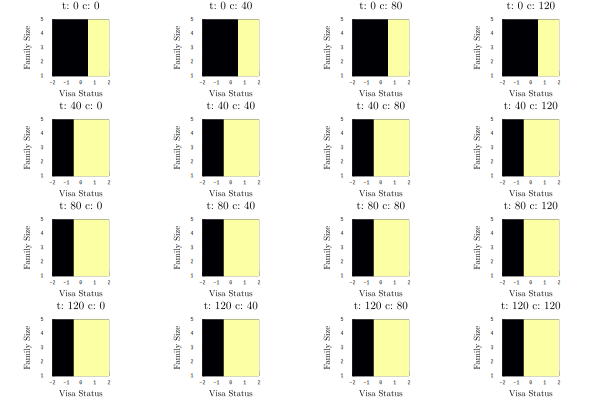

In [57]:
vis_all(mdp_policy) 
#savefig(, "mdp_policy") 

**OLD CODE**

In [36]:
# #***** OLD ONE THAT WORKED ******
# function T(s::State, a::Action)
#     next_states = []
#     if validtime(s) 
        
#         f′ = rand(params.family_sizes) # pull according to those probabilities 
#         v′ = rand(params.visa_status) # TODO: possibly make this weighted in some way 
#         # keep pushing to next states and have a bigger associated probability mass with those possible next states. 
#         # need a for loop iterating over all family sizes and and visa statuses 
        
#         if a == ACCEPT 
#             next_state_accept = State(s.c - s.f, s.t - 1, f′, v′) # they get seats
#             next_state_reject = State(s.c, s.t - 1, f′, v′)
#             push!(next_states, next_state_accept)
#             push!(next_states, next_state_reject)
#             if !validcapacity(next_state_accept) 
#                 probabilities = [0, 1] #no room for full family :( so we make probability 0 to accept and 1 reject
#             else
#                 probabilities = [.80, .20]
#             end

#         elseif a == REJECT
#             probabilities = [1.0]
#             push!(next_states, State(s.c, s.t - 1, f′, v′))
#         end
#     else
#         push!(next_states,params.null_state)
#         probabilities = [1]
#     end
#     return SparseCat(next_states, probabilities)
# end

In [37]:
# function getmetrics(policy, mdp)
#     # I think this somehow needs to simulated in our rollout 
#     total_people = 0
#     total_accept = 0
#     total_reject = 0
#     total_accepted_people = 0 
    
#     # Initialize visa_statuses dictionary
#     visa_statuses = params.visa_status
#     visa_dict = Dict()
#     for v in visa_statuses
#         visa_dict[v] = 0
#     end
    
#     for c in 0:params.capacity # capacity ends at 0 
#         for t in 0:params.time # time ends at 0 
#             for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
#                 for v in params.visa_status # actual visa statuses  
#                     state = State(c, t, f, v)
#                     total_people += f 
#                     if action(policy, state) == ACCEPT
#                         total_accept += 1
#                         total_accepted_people += f
#                         visa_dict[v] += 1
#                     else 
#                         total_reject += 1
#                     end
#                 end        
#             end
#         end
#     end
    
#     print("Total people: ", total_people, )
#     print("Total accept: ", total_accept)
#     print("Total reject: ", total_reject)
#     visa_dict 
       
# end 

In [38]:
# getmetrics(policy, mdp)

In [39]:
# function getmetrics(policy, mdp)
#     # I think this somehow needs to simulated in our rollout 
#     total_people = 0
#     total_accept = 0
#     total_reject = 0
#     total_accepted_people = 0 
    
#     # Initialize visa_statuses dictionary
#     visa_statuses = params.visa_status
#     visa_dict = Dict()
#     for v in visa_statuses
#         visa_dict[v] = 0
#     end
    
#     for c in 0:params.capacity # capacity ends at 0 
#         for t in 0:params.time # time ends at 0 
#             for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
#                 for v in params.visa_status # actual visa statuses  
#                     state = State(c, t, f, v)
#                     total_people += f 
#                     if action(policy, state) == ACCEPT
#                         total_accept += 1
#                         total_accepted_people += f
#                         visa_dict[v] += 1
#                     else 
#                         total_reject += 1
#                     end
#                 end        
#             end
#         end
#     end
    
#     print("Total people: ", total_people, )
#     print("Total accept: ", total_accept)
#     print("Total reject: ", total_reject)
#     visa_dict 
       
# end 

In [40]:
# # for reference, this is what is happening in sim
# # b = initialize_belief(up, b0)

# r_total = 0.0
# d = 1.0
# while !isterminal(pomdp, s)
#     a = action(policy, b)
#     s, o, r = @gen(:sp,:o,:r)(pomdp, s, a) # gen is 
#     r_total += d*r
#     d *= discount(pomdp)
#     b = update(up, b, a, o)
# end

# gen is     
#     sp = rand(transition(pomdp, s, a))
#     o = rand(observation(pomdp, s, a, sp))
#     r = reward(pomdp, s, a, sp, o)
#     s = sp
# function simulation(policy, mdp)
#     sim = RolloutSimulator()
#     r = simulate(sim, mdp, policy) #accumulated discounted reward 
#     # could we also return the number of ppl on the plane? 
#     return r
# end
# sim w/ out history 
# function simulation(policy, mdp)
#     sim = RolloutSimulator()
#     r = simulate(sim, mdp, policy) #accumulated discounted reward 
#     # could we also return the number of ppl on the plane? 
#     return r
# end
# INTEGRATE HISTORY HERE https://juliapomdp.github.io/POMDPSimulators.jl/latest/histories/#Examples and use in stats

In [41]:
# function simulation(policy, mdp)
#     hr = HistoryRecorder()
#     #sim = RolloutSimulator()
#     history = simulate(hr, mdp, policy)
#     #r = simulate(sim, mdp, policy) #accumulated discounted reward 
#     # could we also return the number of ppl on the plane? 
#     return history
# end

In [42]:
# function reward_simulations(policy, mdp, n_sims) # n is number of times to run 
#     policy_rewards = []
#     for i in 1:n_sims
#         push!(policy_rewards, simulation(policy, mdp))
#     end
#     std_policy_reward = std(policy_rewards)
#     mean_policy_reward = mean(policy_rewards)
#     return mean_policy_reward, std_policy_reward
# end

In [43]:
   
#     mean_total_reward = round(mean(list_total_reward);digits=2)
#     std_total_reward = round(std(list_total_reward);digits=2) # double check if should be discounted reward ? 
#     mean_total_accepted_people = round(mean(list_total_accepted_people);digits=2)
#     std_total_accepted_people = round(std(list_total_accepted_people);digits=2)
# #     mean_total_accepted_families = round(mean(list_total_accepted_families);digits=2)
# #     std_total_accepted_families = round(std(list_total_accepted_families);digits=2)
#   #  println("$str_policy & $mean_total_reward \$\\pm\$ $std_total_reward")
    
#     # fix seperately - get mean and std. for each number of ppl accepted 
    
#     println("$str_policy & $mean_total_reward \$\\pm\$ $std_total_reward & $mean_total_accepted_people \$\\pm\$ $std_total_accepted_people")
            

In [44]:
# DEBUGGING DICTIONARY NOTES 
    
#     base_dict = Dict{Int64, Int64}(0=>0)
#    # println("base_dict_initial ", base_dict)
#     for dict in list_visa_dict_accepts
#         base_dict = merge(counter(base_dict), counter(dict)).map
# #         println("new dict ", dict)
# #         println("base_dict + dict")
# #         println("base_dict_added ", base_dict)
#     end
#     println(base_dict)
    
#        # nums_visa = keys(dict)
#         # put togehter the valyes of all the dictionaries and divide by the number of dictionaries 
#         # I want to build a list of each of the visa types in this particular dict and 
# #         for visa_type in keys(dict)
# #             println(visa_type, dict[visa_type])
# #         end
        
    
# #     mean_std_reward = mean_std(list_total_reward, false)
# #     mean_std_total_accepted_people = mean_std(list_total_accepted_people, true)
# #     println("$str_policy & $(mean_std_reward[1]) \$\\pm\$ $(mean_std_reward[2]) & $(mean_std_total_accepted_people[1]) \$\\pm\$ $(mean_std_total_accepted_people[2])")

    

In [45]:
#     policies = Dict("mdp-policy"=>mdp_policy, 
#         "AcceptAll-policy"=>AcceptAll_policy, 
#         "AMCITS-policy"=>AMCITS_policy, 
#         "SIV-AMCITS-policy"=>SIV_AMCITS_policy, 
#         "AfterThresholdAMCITS-policy"=>AfterThresholdAMCITS_policy, 
#         "BeforeThresholdAMCITS-policy"=>BeforeThresholdAMCITS_policy)
    
# #     # definitely could have more statuses
#     v_stringtoint = Dict("ISIS-k"=>-2,
#         "Taliban"=>-1,
#         "Afghan"=>0,
#         "SIV"=>1,
#         "AMCIT"=>2)
    
#      v_inttostring = Dict(-2=>"ISIS-k",
#         -1=>"Taliban",
#         0=>"Afghan",
#         1=>"SIV",
#         2=>"AMCIT")
    